In [3]:
import os
import numpy as np
import json
from skimage.draw import polygon
from PIL import Image
import matplotlib.pyplot as plt
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.networks.layers import Norm
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import time
import copy
import random
# import Augmentor
import cv2

In [ ]:
import json

# Read json file
with open('val.json', 'r') as f:
    data = json.load(f)

In [ ]:
root = 'd:\\programming\\unet-livecell-project'
image_dir = r'D:\programming\unet-livecell-project\test_image\train_images'

### Process the masks based on .json file

In [ ]:
# Get name of each image
image_name_list = []
files = os.listdir(image_dir)
for file in files:
    name, extension = os.path.splitext(file)
    if extension == '.tif':
        image_name_list.append(name)

In [ ]:
image_id_to_segmentation = {}

# Collecting segmentation for each image_id
for image in data['images']:
    name, extension = os.path.splitext(image["file_name"])
    if name in image_name_list:
        image_id = image['id']
        segmentation_list = []
        for ann in data['annotations']:
            if ann['image_id'] == image_id:
                # Create a list of segmentation for each image, each list have corresponding (x, y) coordinate
                segmentation_list += ann['segmentation']
        image_id_to_segmentation[image_id] = {}
        image_id_to_segmentation[image_id]['segmentation'] = segmentation_list
        image_id_to_segmentation[image_id]['name'] = name

In [ ]:
shape = (521, 705, 3)
# Create a mask for corresponding image id
for image_id in image_id_to_segmentation.keys():
    combined_mask = np.zeros(shape, dtype=np.float32)
    segmentation_list = image_id_to_segmentation[image_id]['segmentation']
    for segmentation in segmentation_list:
        mask = np.zeros(shape, dtype=np.bool8)
        rr, cc = polygon(segmentation[1::2], segmentation[0::2])
        mask[rr, cc] = 1
        # combined_mask += mask
        combined_mask = np.maximum(mask, combined_mask)
    name = image_id_to_segmentation[image_id]['name']
    plt.imshow(combined_mask, cmap='gray')
    # Save mask as gray scale image
    plt.imsave(rf'test_image/train_masks/{name}.png', combined_mask, cmap='gray')
    img_pil = Image.open(rf'test_image/train_masks/{name}.png')
    img_pil = img_pil.convert('L')
    img_pil.save(os.path.join(root, rf'test_image/train_masks/{name}.png'))

In [ ]:
# Transform all the images to gray scale images
def transform_image(folder, save_folder, json_file):
    file_name_list = []
    for image in json_file['images']:
        file_name = image["file_name"]
        name, extension = os.path.splitext(file_name)
        file_name_list.append(name)
    for image in os.listdir(folder):
        name, extension = os.path.splitext(image)
        if name in file_name_list:
            img_path = os.path.join(folder, image)
            image = Image.open(img_path)
            image = image.convert('L')
            image.save(f'{save_folder}/{name}.png')
# image_dir = r'D:\programming\unet-livecell-project\images\livecell_test_images'
save_folder = r'D:\programming\unet-livecell-project\test_image\train_images'
transform_image(image_dir, save_folder=save_folder, json_file=data)
            

In [ ]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """Function using for elastic tranformation the dataset."""
    if random_state is None:
        random_state = np.random.RandomState()

    shape_size = image.shape[:2]

    # Downscaling the random grid and then upsizing post filter
    # improves performance. Approx 3x for scale of 4, diminishing returns after.
    grid_scale = 4
    alpha //= grid_scale  # Does scaling these make sense? seems to provide
    sigma //= grid_scale  # more similar end result when scaling grid used.
    grid_shape = (shape_size[0]//grid_scale, shape_size[1]//grid_scale)

    blur_size = int(4 * sigma) | 1
    rand_x = cv2.GaussianBlur(
        (random_state.rand(*grid_shape) * 2 - 1).astype(np.float32),
        ksize=(blur_size, blur_size), sigmaX=sigma) * alpha
    rand_y = cv2.GaussianBlur(
        (random_state.rand(*grid_shape) * 2 - 1).astype(np.float32),
        ksize=(blur_size, blur_size), sigmaX=sigma) * alpha
    if grid_scale > 1:
        rand_x = cv2.resize(rand_x, shape_size[::-1])
        rand_y = cv2.resize(rand_y, shape_size[::-1])

    grid_x, grid_y = np.meshgrid(np.arange(shape_size[1]), np.arange(shape_size[0]))
    grid_x = (grid_x + rand_x).astype(np.float32)
    grid_y = (grid_y + rand_y).astype(np.float32)

    distorted_img = cv2.remap(image, grid_x, grid_y,
        borderMode=cv2.BORDER_REFLECT_101, interpolation=cv2.INTER_LINEAR)

    return distorted_img

### Defining the model

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        # self.to("cuda")
        
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


### Defining the dataset

In [5]:
class Dataset():
    """Load and transform the dataset. The train dataset will have 2 parts: normal and augmented, therefore the size will be doubled"""
    def __init__(self, image_dir, mask_dir, transform=None, train = False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.train = train
        self.images = os.listdir(image_dir)
    def __len__(self):
        if self.train is True:
            self.images = os.listdir(self.image_dir) * 2
            return len(self.images)
        else:
            self.images = os.listdir(self.image_dir)
            return len(self.images)

    def __getitem__(self, index):
        if self.train is True:
            img_index = index % len(self.images)
            
            # Normal transform to tensor of the first half of the training dataset
            if index < len(self.images)//2:
                img_path = os.path.join(self.image_dir, self.images[img_index])
                mask_path = os.path.join(self.mask_dir, self.images[img_index])
                
                # Convert the image to RGB image and crop
                image = Image.open(img_path)
                image = np.array(image.convert('RGB'))
                image = image[:333, :434, :]  
                
                # Convert the mask to binary image and crop
                mask = Image.open(mask_path)
                mask = np.array(mask.convert('L'))
                mask = mask[:333, :434]
                
                image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
                mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
                if self.transform:
                    image = self.transform(image)
                    mask = self.transform(mask)
                    
            # Augmented transformation with elastic transform and rotate for the second half of the training dataset
            else:
                img_path = os.path.join(self.image_dir, self.images[img_index])
                mask_path = os.path.join(self.mask_dir, self.images[img_index])

                angle = random.randint(0, 180)
                
                image = Image.open(img_path)
                # Rotate the image
                image = image.rotate(angle)
                # Convert the image to RGB image and crop
                image = np.array(image.convert('RGB'))
                image = image[:333, :434, :]                
                
                mask = Image.open(mask_path)
                # Rotate the mask with the same angle
                mask = mask.rotate(angle)
                # Convert the mask to binary image and crop
                mask = np.array(mask.convert('L'))
                mask = mask[:333, :434]
                image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
                mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
            
                if self.transform:
                    image = self.transform(image)
                    mask = self.transform(mask) 
                    
                    image = torch.tensor(image)
                    mask = torch.tensor(mask)
                    
                    image = image.permute(1, 2, 0).numpy()
                    mask = mask.squeeze(0).numpy()
                    
                    # Apply elastic transformation with the fix seed for both image and mask
                    random_state = np.random.RandomState(50)
                    image = elastic_transform(image, mask.shape[1] * 2, mask.shape[1] * 0.08, np.random.RandomState())
                    mask = elastic_transform(mask, mask.shape[1] * 2, mask.shape[1] * 0.08, np.random.RandomState())
                    
                    image = torch.tensor(image).permute(2, 0, 1)
                    mask = torch.tensor(mask).unsqueeze(0)
                    
        # Normal transform for validation and test dataset        
        else:
            img_path = os.path.join(self.image_dir, self.images[index])
            mask_path = os.path.join(self.mask_dir, self.images[index])
            
            # Convert the image to RGB image and crop
            image = Image.open(img_path)
            image = np.array(image.convert('RGB'))
            image = image[:333, :434, :]  
            
            # Convert the mask to binary image and crop
            mask = Image.open(mask_path)
            mask = np.array(mask.convert('L'))
            mask = mask[:333, :434]
            
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
            
            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)
        
        return image, mask
    


In [6]:

# TRAIN_IMG_DIR = r"D:\programming\unet-livecell-project\dataset\train_images"
# TRAIN_MASK_DIR = r"D:\programming\unet-livecell-project\dataset\train_masks"
# VAL_IMG_DIR = r"D:\programming\unet-livecell-project\dataset\val_images"
# VAL_MASK_DIR = r"D:\programming\unet-livecell-project\dataset\val_masks"
TEST_IMG_DIR = r"/Users/menelaos/Desktop/U-Nets/dataset/test_images"
TEST_MASK_DIR = r"/Users/menelaos/Desktop/U-Nets/dataset/test_masks/"


IMAGE_HEIGHT = 333  # 293 originally
IMAGE_WIDTH = 434 # 392 originally
EPOCHS = 30
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = UNET()
model.to(DEVICE)

# Normal transformation 
transform = torchvision.transforms.Compose(
    [   
        transforms.ToPILImage(),
        transforms.ToTensor(),      
    ],
)

# train_ds = Dataset(image_dir=TRAIN_IMG_DIR, mask_dir=TRAIN_MASK_DIR, transform= transform, train=True)
# val_ds = Dataset(image_dir=VAL_IMG_DIR, mask_dir=VAL_MASK_DIR, transform= transform)
test_ds = Dataset(image_dir=TEST_IMG_DIR, mask_dir=TEST_MASK_DIR, transform=transform)
# train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=2, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=2, shuffle=True)

loss_fn = DiceLoss(sigmoid=True,squared_pred=True)
# loss_fn = nn.BCELoss() #RuntimeError: Unable to find a valid cuDNN algorithm to run convolution
# loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5, amsgrad=True)

### Sample images of the training data

In [ ]:
import matplotlib.gridspec as gridspec

(images, masks) = next(iter(train_loader))

fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.1, hspace=0.1)

ax = plt.subplot(gs[0, 0])
ax.imshow(images[0].permute(1, 2, 0), cmap='gray')
ax = plt.subplot(gs[0, 1])
ax.imshow(masks[0].permute(1, 2, 0), cmap='gray')

ax = plt.subplot(gs[1, 0])
ax.imshow(images[1].permute(1, 2, 0), cmap='gray')
ax = plt.subplot(gs[1, 1])
ax.imshow(masks[1].permute(1, 2, 0), cmap='gray')

# show the plot
plt.show()


### The training

In [ ]:
train_loss_list = []
val_loss_list = []
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
smallest_loss = 1.0
for epoch in range(EPOCHS):
    # Train
    train_epoch_loss = 0.0
    for idx, (image, mask) in enumerate(train_loader):
        image = image.to(device=DEVICE)
        mask = mask.to(device=DEVICE)
        optimizer.zero_grad()
        prediction = model(image)
        
        loss = loss_fn(prediction, mask)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    epoch_loss = train_epoch_loss/len(train_loader)
    print("Epoch [{}/{}], Step [{}/{}], train_loss: {:.4f}".format(epoch+1, EPOCHS, idx+1, len(train_loader), epoch_loss))
    train_loss_list.append(epoch_loss)
    # Val
    with torch.no_grad():
        val_loss = 0.0
        for idx, (image, mask) in enumerate(val_loader):
            image = image.to(device=DEVICE)
            mask = mask.to(device=DEVICE)
            prediction = model(image)
            
            loss = loss_fn(prediction, mask)
            val_loss += loss.item()
        epoch_loss = val_loss/len(val_loader)
        print("Epoch [{}/{}], Step [{}/{}], val_loss: {:.4f}".format(epoch+1, EPOCHS, idx+1, len(val_loader), epoch_loss))
        if epoch_loss < smallest_loss:
            smallest_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        val_loss_list.append(epoch_loss)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
print('Smallest val loss: {:4f}'.format(smallest_loss))

In [ ]:
# Save model with the least loss
torch.save(best_model_wts, 'model/BEST_model_augmented_diceloss.pth')

In [ ]:
performance = {}
performance["train_loss"] = train_loss_list
performance["val_loss"] = val_loss_list
with open('performance_model_new_augmented_diceloss.txt', 'w') as f:
    f.write(str(performance))

In [ ]:
x = np.linspace(0, EPOCHS, EPOCHS)
plt.plot(x, val_loss_list)

### Evaluation

In [59]:
model = UNET()
state_dict = torch.load('BEST_model_augmented_diceloss.pth', map_location=torch.device('cpu'))
# state_dict = torch.load('best_model_333_434_batch2_diceloss.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.to(device=DEVICE)


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [8]:
# Calculate the total loss on the test dataset
model.eval()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
with torch.no_grad():
    val_loss = 0.0
    total_loss = 0.0
    for idx, (image, mask) in enumerate(test_loader):
        image = image.to(device=DEVICE)
        mask = mask.to(device=DEVICE)
        prediction = model(image)
        
        loss = loss_fn(prediction, mask)
        val_loss += loss.item()
    total_loss = val_loss/len(test_loader)
print(total_loss)

KeyboardInterrupt: 

torch.Size([333, 434])


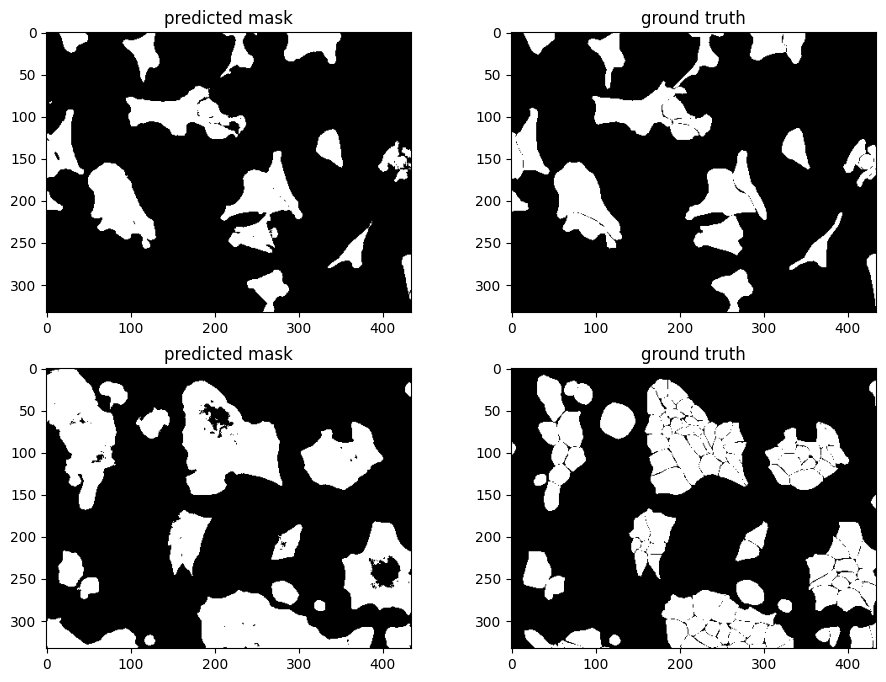

In [60]:
import torchvision.transforms as T
from torchmetrics.classification import ConfusionMatrix
from ignite.metrics import *
from collections import namedtuple
import numpy as np
import cv2
# Display some samples of ground true and prediction of the test dataset
model.eval()
transform = T.ToPILImage()
# for idx, (input, mask) in enumerate(test_loader):

#     # image1 = input[idx].squeeze(0)
#     # img = transform(image1)

#     # mask1 = mask[idx].squeeze(0)
#     # mask1 = transform(mask1)
#     # img.show()
#     # mask1.show()

#     image = input[idx].unsqueeze(0)
#     image = image.to(DEVICE)
#     mask = mask.to(DEVICE)
    
#     preds = torch.sigmoid(model(image))
#     preds = (preds > 0.5).float()
#     # print(loss_fn(preds, mask[idx].unsqueeze(0)))
#     preds = preds.cpu()
#     preds = preds.squeeze(0).squeeze(0)
    
#     mask = mask[idx].squeeze(0).cpu()
#     fig, ax = plt.subplots(2, 2, figsize=(15,30))
#     ax = ax.flatten()
#     ax[idx].imshow(preds, cmap='gray')
#     ax[idx].set_title('predicted mask')
#     ax[idx+1].imshow(mask, cmap='gray')
#     ax[idx+1].set_title('ground truth')
#     if idx>2: break

input, mask = next(iter(test_loader))
input1, mask1 = next(iter(test_loader))

image = input[1].unsqueeze(0)
image = image.to(DEVICE)
mask = mask.to(DEVICE)
preds = torch.sigmoid(model(image))
preds = (preds > 0.5).float()
# print(loss_fn(preds, mask[1].unsqueeze(0)))
preds = preds.cpu()
preds = preds.squeeze(0).squeeze(0)
mask = mask[1].squeeze(0).cpu()

image1 = input1[1].unsqueeze(0)
image1 = image1.to(DEVICE)
mask1 = mask1.to(DEVICE)
preds1 = torch.sigmoid(model(image1))
preds1 = (preds1 > 0.5).float()
# print(loss_fn(preds1, mask1[1].unsqueeze(0)))
preds1 = preds1.cpu()
preds1 = preds1.squeeze(0).squeeze(0)
mask1 = mask1[1].squeeze(0).cpu()
print(np.shape(mask1))
fig, ax = plt.subplots(2, 2, figsize=(11,8))
ax = ax.flatten()
ax[0].imshow(preds, cmap='gray')
ax[0].set_title('predicted mask')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('ground truth')
ax[2].imshow(preds1, cmap='gray')
ax[2].set_title('predicted mask')
ax[3].imshow(mask1, cmap='gray')
ax[3].set_title('ground truth')

img1 = transform(preds)
img2 = transform(mask)
img3 = transform(preds1)
img4 = transform(mask1)

img1.save("img1.png")
img2.save("img2.png")
img3.save("img3.png")
img4.save("img4.png")
# preds1 = preds1.numpy()
# mask1 = mask1.numpy()
# print(np.shape(preds1))
# print(np.shape(mask1))

    # image = input[idx].squeeze(0)
    # img = transform(image)

    # mask = mask[idx].squeeze(0)
    # mask = transform(mask)
    # img.show()
    # mask.show()


30


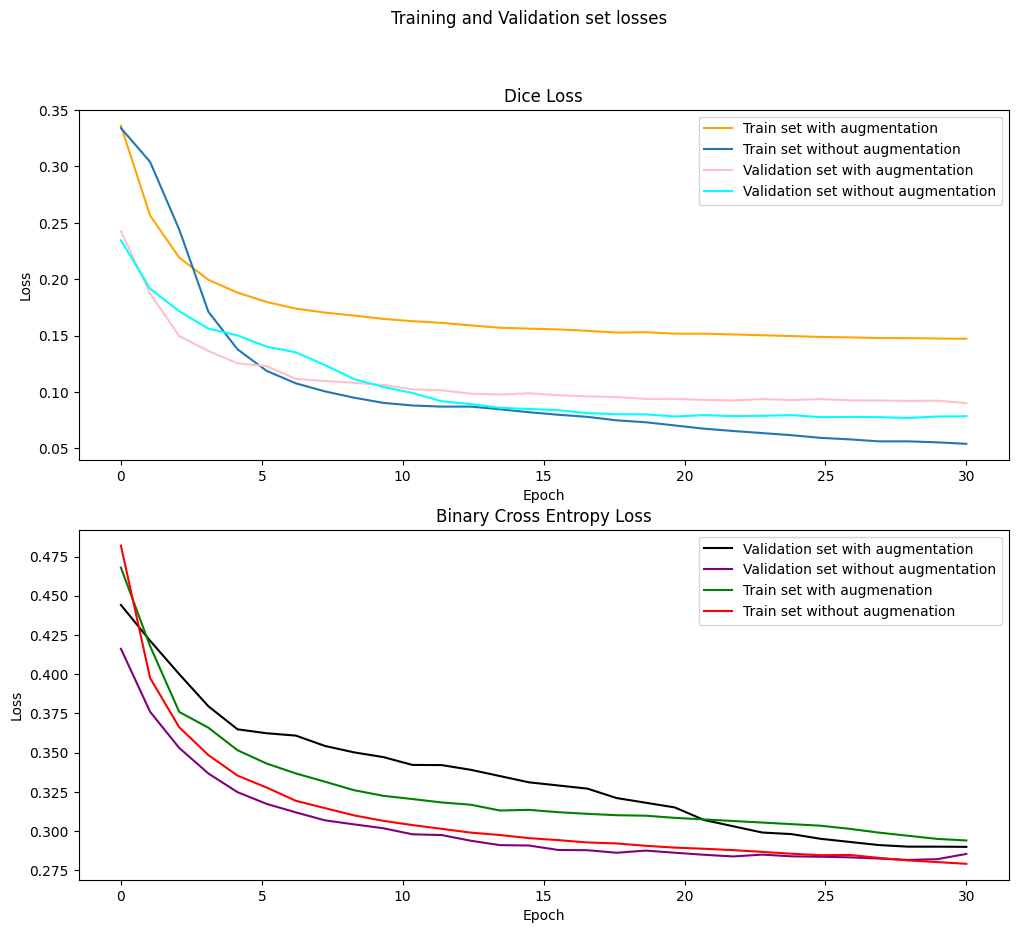

In [46]:
import numpy as np
import matplotlib.pyplot as plt
train_loss_dice_loss = [0.3340285271860793, 0.3040285271860793, 0.2440285271860793 ,0.1710756943845091, 0.13772389573165433, 0.11861058409644788, 0.10757184997107483, 0.10041816272729613, 0.09483244108361014, 0.09025781163232988, 0.087931398877236, 0.086931398877236, 0.086931398877236, 0.08455976430639868, 0.08194521344366157, 0.0797033566453376, 0.07784553429338534, 0.0747538894190543, 0.0730596026370636, 0.07021165956068817, 0.06735620280281364, 0.06530580562136254, 0.06345857081553867, 0.06156623591592949, 0.059211499100945975, 0.05785884783887205, 0.056109026037016355, 0.056108026037016355, 0.0552431287400546, 0.05393171185157829]
train_loss_aug = [0.33617319221815173, 0.2564796611217962, 0.21906513645964554, 0.1994000358537419, 0.1880355635879928, 0.17975613363601334, 0.1738428158061567, 0.1703347757066059, 0.16766578125460085, 0.16475587454127846, 0.16270055333000505, 0.16123065992797184, 0.1589563859526157, 0.15691520922456212, 0.1560656642132302, 0.15542666633687025, 0.15416684564450753, 0.15258792636348134, 0.15290127837635492, 0.15165129233820077, 0.15164737452938684, 0.15092443232629052, 0.15020584154271122, 0.14953032088287202, 0.14873647922591554, 0.14833534380872096, 0.14774896971965523, 0.14767886892690263, 0.1472915241230686, 0.14711451086413158]
train_loss_bce = [0.4819337894843244, 0.39752828568182746, 0.3661234110892941, 0.3483798183510115, 0.33529048901018565, 0.32768702221896445, 0.31922672866578383, 0.3145553126108542, 0.3099212844854915, 0.3064480606405768, 0.3037415172021317, 0.3013558227012642, 0.29893823630799315, 0.29742075295808024, 0.2954218890541321, 0.29415800355122407, 0.29266275805298475, 0.29204222986210543, 0.2905380182258009, 0.28937627183018694, 0.2886598337549188, 0.2877741042604037, 0.2866605258216074, 0.2854811878807123, 0.2845256513725485, 0.28471672703679113, 0.28282096517860067, 0.2812110450413251, 0.28014509703781704, 0.27905304662163466]
train_loss_bce_aug = [0.4679115207020282, 0.4179115207020282, 0.3759115207020282,0.3658409265513851, 0.35147337386457056, 0.34298155396017554, 0.33667457420636, 0.3314041203095892, 0.32598373751007625, 0.3224151698472808, 0.3203493057279246, 0.3181778857743875, 0.316730600275763, 0.3130479398250131, 0.31345779611407737, 0.3119659836975439, 0.3109212844854915, 0.31004480606405768, 0.3097415172021317, 0.3083558227012642, 0.3073558227012642, 0.3063558227012642, 0.3053558227012642, 0.3043558227012642,0.3033558227012642, 0.3013558227012642, 0.29893823630799315, 0.29693823630799315, 0.29493823630799315, 0.29393823630799315]

val_loss_dice_aug = [0.24259186167466013, 0.1872425539451733, 0.14951586524645488, 0.13633161385854084, 0.12528113398635596, 0.12285906296027334, 0.11147801834240294, 0.10965392286317391, 0.10810115556967886, 0.1060784261477621, 0.10226912446189344, 0.10140470893759476, 0.09843231387305677, 0.09762754293910245, 0.09875753835627907, 0.09701408471977502, 0.09601021314922133, 0.09540889420007405, 0.09376137078854076, 0.09380882277823331, 0.09290328893745155, 0.09242054213557327, 0.09361121204861424, 0.09275175071599191, 0.09359990128299646, 0.09250157036279377, 0.09236287202751427, 0.09198984472375167, 0.09217464882030822, 0.09003881101022687]
val_loss_dice_woaug = [0.234544643912399,0.191544643912399,0.171544643912399, 0.15607461756572388, 0.15007461756572388, 0.14007461756572388,0.13507461756572388, 0.12372803008347227, 0.11133887840990435, 0.10432790591005693, 0.09903020524142081, 0.09169066496062697, 0.0891155647604089, 0.08588697282891525, 0.08480783083982635, 0.08387571249091834, 0.08111213790742974, 0.0801958185538911, 0.08006096356793453, 0.07819144955852575, 0.07936842044194539, 0.07847609499044586, 0.07877728353466903, 0.07937305391880504, 0.0775878133481009, 0.07775758379384091, 0.07758894050330446, 0.07684257386023538, 0.07815021203275313, 0.07839937952526829]
val_loss_bce_woaug = [0.4161523569048497, 0.3760266379306191, 0.35293656838567633, 0.33663991313231617, 0.32472935104579254, 0.3172472053452542, 0.3118409267120194, 0.3067716211603399, 0.3041821922126569, 0.3017332145780848, 0.2978655663760085, 0.29738673057995346, 0.2937723874000081, 0.29097365237641754, 0.29071616820598906, 0.28787487614573093, 0.2877215120353197, 0.2861049285321905, 0.2874814808630107, 0.2861130427373083, 0.28482056158153635, 0.2837472566909957, 0.28492254745541956, 0.28382838470371147, 0.28355150345647545, 0.2831786125898361, 0.282401716578425, 0.28152327864316473, 0.2820208792362297, 0.2853520488529875]
val_loss_bce_aug = [0.4441150411179191, 0.42130535866921405, 0.39999226307868956, 0.37950677798505417, 0.3648041176879615, 0.3623041176879615, 0.3608041176879615, 0.3542041176879615, 0.3501041176879615, 0.3471041176879615, 0.3421041176879615, 0.34200041176879615, 0.33900041176879615, 0.33500041176879615, 0.33100041176879615, 0.32900041176879615, 0.32700041176879615, 0.32100041176879615, 0.31800041176879615, 0.31500041176879615, 0.30700041176879615, 0.30300041176879615, 0.29900041176879615, 0.29800041176879615, 0.29500041176879615, 0.29300041176879615, 0.29100041176879615,  0.29000041176879615, 0.28999041176879615, 0.2898704117687961]
# x = np.linspace(0,30,30)
x = np.linspace(0,30,30)
fig, axs = plt.subplots(2, figsize=(12, 10))
fig.suptitle('Training and Validation set losses')
axs[0].plot(x, train_loss_aug, label= 'Train set with augmentation', c = 'orange')
axs[0].plot(x, train_loss_dice_loss, label= 'Train set without augmentation')
axs[0].plot(x, val_loss_dice_aug, label= 'Validation set with augmentation', c = 'pink')
axs[0].plot(x, val_loss_dice_woaug, label= 'Validation set without augmentation', c = 'cyan')
axs[0].set_title('Dice Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(x, val_loss_bce_aug, label = 'Validation set with augmentation', c = 'black')
axs[1].plot(x, val_loss_bce_woaug, label = 'Validation set without augmentation', c = 'purple')
axs[1].plot(x, train_loss_bce_aug, label = 'Train set with augmenation', c = 'green')
axs[1].plot(x, train_loss_bce, label = 'Train set without augmenation', c = 'red')
axs[1].set_title('Binary Cross Entropy Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

axs[0].legend()
axs[1].legend()
print(len(train_loss_aug))

In [22]:
import cv2
import numpy as np

img1 = cv2.imread("img1.png")
img2 = cv2.imread("img2.png")

imggray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
imggray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

for i in range(np.shape(imggray1)[0]):
    for j in range(np.shape(imggray1)[1]):
       if imggray1[i][j] > 0:
           imggray1[i][j] = 255

for i in range(np.shape(imggray2)[0]):
    for j in range(np.shape(imggray2)[1]):
       if imggray2[i][j] > 0:
           imggray2[i][j] = 255

bitwiseAnd = cv2.bitwise_and(imggray1, imggray2, mask=None)
bitwiseOr = cv2.bitwise_or(imggray1, imggray2, mask=None)

sum1 = 0
sum3 = 0
for i in range(np.shape(bitwiseOr)[0]):
    for j in range(np.shape(bitwiseOr)[1]):
        sum1 += bitwiseOr[i][j]

for i in range(np.shape(bitwiseAnd)[0]):
    for j in range(np.shape(bitwiseAnd)[1]):
        sum3 += bitwiseAnd[i][j]

IoU = sum3/sum1  


0.8624313710717885
